In [2]:
import pandapower as pp

import pandapower.converter as pc

# Load the MATPOWER case using pandapower
# pp_net = pc.from_mpc("data/Texas2k_series25_case1_summerpeak.m")
pp_net = pc.from_mpc("data/ACTIVSg2000_quadratic.m")

# Run power flow
pp.runpp(pp_net)

if pp_net["converged"]:
    print("Pandapower power flow solved successfully.")
else:
    print("Pandapower power flow did not converge.")

/Users/kibaekkim/Documents/REPOS/C.Lee--2025-Summer-Internship-Materials/.venv/lib/python3.10/site-packages/pandapower/converter/pypower/from_ppc.py:334: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  branch_lookup.loc[is_trafo, "element"] = idx_trafo
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


Pandapower power flow solved successfully.


In [3]:
def parse_substation_coords(aux_file):
    coords = {}
    with open(aux_file, 'r') as f:
        lines = f.readlines()
    
    substation_section = False
    for line in lines:
        line = line.strip()
        if line.startswith('Substation') or line.startswith('DATA (Substation'):
            substation_section = True
            continue
        if substation_section:
            if line == '' or line.startswith('}'):
                break  # end of substation section
            # Line format example: 1 "ODESSA 2" "1"  31.841400 -102.315000 "" "NO "
            parts = line.split('"')
            if len(parts) >= 5:
                # parts[1] is bus name, parts[4] contains lat lon and extras
                bus_name = parts[1]
                rest = parts[4].strip().split()
                try:
                    lat = float(rest[0])
                    lon = float(rest[1])
                    coords[bus_name] = (lat, lon)
                except:
                    pass
    return coords

aux_file = 'data/ACTIVSg2000.aux'
bus_coords = parse_substation_coords(aux_file)

print(f"Extracted {len(bus_coords)} bus coordinates")
print(list(bus_coords.items())[:10])


Extracted 1250 bus coordinates
[('ODESSA 2', (31.906736, -102.262348)), ('PRESIDIO 2', (29.888046, -104.519139)), ('O DONNELL 1', (32.926389, -101.647778)), ('BIG SPRING 5', (32.2075, -101.388333)), ('VAN HORN', (31.09348, -104.624514)), ('IRAAN 2', (30.931467, -102.201433)), ('PRESIDIO 1', (29.6, -104.3)), ('SANDERSON', (30.028067, -101.970461)), ('MONAHANS 2', (31.484586, -103.161046)), ('GRANDFALLS', (31.169523, -103.085134))]


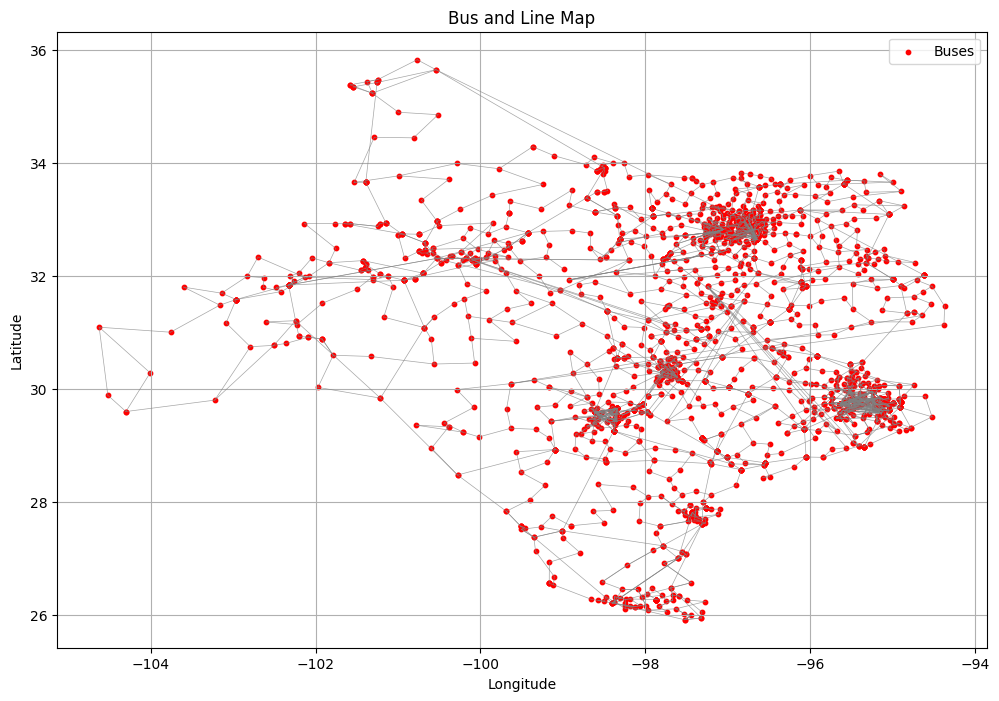

In [11]:
import matplotlib.pyplot as plt

# Extract bus indices and names from pp_net
bus_names = pp_net.bus['name'].values
bus_indices = pp_net.bus.index.values

# Prepare bus coordinates for plotting (allow partial match)
bus_x = []
bus_y = []
bus_idx_to_xy = {}
for idx, name in zip(bus_indices, bus_names):
    match = next((coord for key, coord in bus_coords.items() if name.startswith(key)), None)
    if match:
        lat, lon = match
        bus_x.append(lon)
        bus_y.append(lat)
        bus_idx_to_xy[idx] = (lon, lat)


plt.figure(figsize=(12, 8))

# Plot lines
for _, line in pp_net.line.iterrows():
    from_bus = line['from_bus']
    to_bus = line['to_bus']
    if from_bus in bus_idx_to_xy and to_bus in bus_idx_to_xy:
        x0, y0 = bus_idx_to_xy[from_bus]
        x1, y1 = bus_idx_to_xy[to_bus]
        plt.plot([x0, x1], [y0, y1], color='gray', linewidth=0.5, alpha=0.7)

# Plot buses
plt.scatter(bus_x, bus_y, c='red', s=10, label='Buses')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bus and Line Map')
plt.legend()
plt.grid(True)
plt.show()